In [7]:
import yaml
import numpy as np
import matplotlib.pyplot as plt

## Pull dataset names and yaml file name from the yaml descibes repository

In [8]:
yamlDir = "."
yaml_file = yamlDir + "/submission.yaml"
yaml_entries = []  # List to store parsed documents

with open(yaml_file, "r") as stream:
    try:
        yaml_entries = list(yaml.safe_load_all(stream))  # Load all YAML documents
    except yaml.YAMLError as exc:
        print(exc)

# Example: Accessing name and data_file from each entry
file_list = []
list_name = []
for entry in yaml_entries:
    file_list.append(entry.get('data_file'))
    list_name.append(entry.get('name'))
    print(entry.get('name'))

None
Signal Channels
Constrained Signal Channels Covariance Matrix
Constraining Channels
Signal And Constraining Channels Covariance Matrix
WC $1\gamma Np$ Energy Distribution
WC $1\gamma 0p$ Energy Distribution
Pandora $1\gamma 1p$ Energy Distribution
Pandora $1\gamma 0p$ Energy Distribution
Constrained Energy Distributions Covariance Matrix
WC $1\gamma Np$ NC Delta Radiative Decay Efficiencies
WC $1\gamma 0p$ NC Delta Radiative Decay Efficiencies
Pandora $1\gamma 1p$ NC Delta Radiative Decay Efficiencies
Pandora $1\gamma 0p$ NC Delta Radiative Decay Efficiencies
WC $1\gamma 0p$ True 0p NC Delta Efficiencies
Pandora $1\gamma 0p$ True 0p NC Delta Efficiencies


#### Identify which titles are for 2D vs. 1D plots (look at your dataset in HEPdata, matches this specific case)

In [9]:
file_list_eff = []
file_name_eff = []
file_list_cov = []
file_name_cov = []
file_list_1D = []
file_name_1D = []
for i in range(len(list_name)):
    if list_name[i] is None:
        continue
    elif "Covariance" in list_name[i]:
        file_list_cov.append(file_list[i][:-5]) #remove the .yaml for ease
        file_name_cov.append(list_name[i])
    elif "Efficiencies" in list_name[i]: #identify
        file_list_eff.append(file_list[i][:-5]) #remove the .yaml for ease
        file_name_eff.append(list_name[i])
    else:
        file_list_1D.append(file_list[i][:-5]) #remove the .yaml for ease
        file_name_1D.append(list_name[i])

### Create Function to pull data columns (after first column)

In [10]:
def pull_dependent_vars(data_list_here):    
    data_series = {}
    for entry in data_list_here:
        name_here = entry['header']['name']
        values = []
        errors = []

        for v in entry['values']:
            values.append(v['value'])
            if 'errors' in v and v['errors']:  # Check for presence of errors
                if 'asymerror' in v['errors'][0]:
                    err_minus = -v['errors'][0]['asymerror']['minus']
                    err_plus = v['errors'][0]['asymerror']['plus']
                else:
                    err_minus = v['errors'][0]['symerror']
                    err_plus = v['errors'][0]['symerror']
            else:
                err_minus, err_plus = 0, 0  # Default to no error if missing

            errors.append([err_minus, err_plus])

        data_series[name_here] = {'values': values, 'errors': np.array(errors).T}  # Transpose errors
    return data_series

## 1D Plots for Data and MC

In [11]:
yaml_names = file_list_1D
yaml_name_pretty = file_name_1D
yaml_dict = {}
for yaml_file in yaml_names:
    print(yaml_file)
    with open(yamlDir + "/" + yaml_file + ".yaml", "r") as stream:
        try:
            yaml_dict[yaml_file] = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)

signals
constraining_channels
wc_1gNp_energy
wc_1g0p_energy
pandora_1g1p_energy
pandora_1g0p_energy


## Load and plot all 1D sets

4
64
7
15
7
15


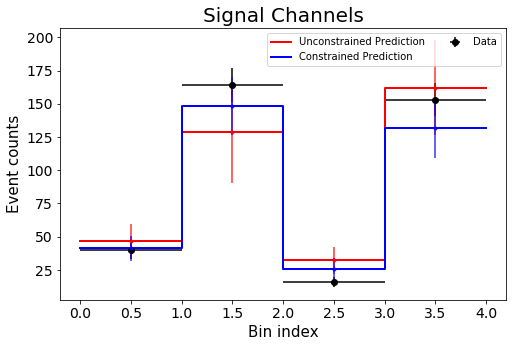

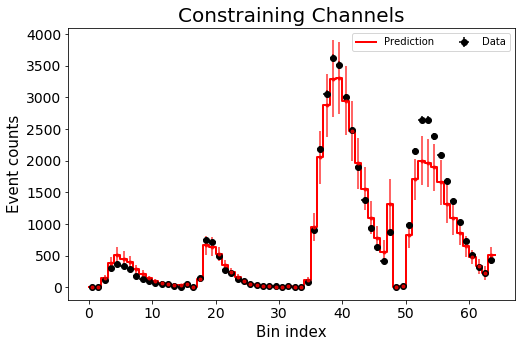

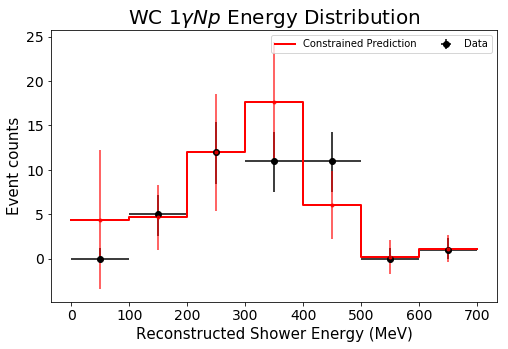

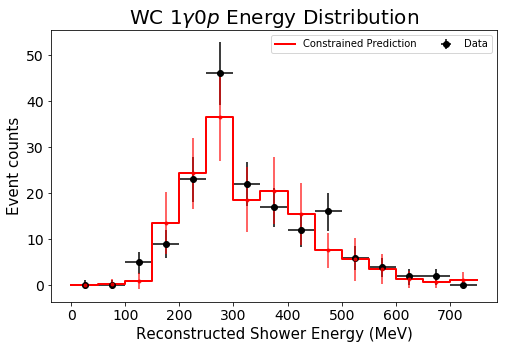

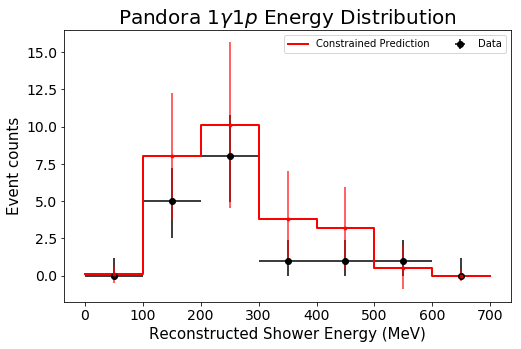

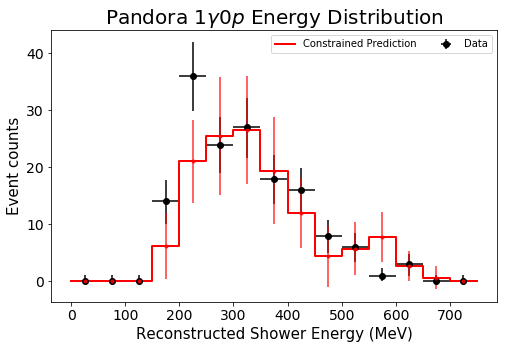

In [12]:
color_data = ["red","blue","lightblue","pink"]
color_other = ["blueviolet","seagreen","orange","cyan","brown","gray","magenta"]

for i in range(len(yaml_names)):
    #### PULL 1D DATASET X-AXIS #######
    
    #Check for 1D, only 1 indepedent variable
    i_vars = 0 #index for single independent variable
    assert len(yaml_dict[yaml_names[i]]["independent_variables"]) == 1, "Plotting 1D only"
    indep_var = yaml_dict[yaml_names[i]]["independent_variables"][i_vars]
        
    center = []
    bin_low = []
    bin_high = []
    xerrors = []
    for v in indep_var['values']:
        center.append((v['low']+v['high'])/2)
        bin_low.append(v['low'])
        bin_high.append(v['high'])
        xerrors.append((v['high']-v['low'])/2.)
    x_values = center
    bin_low.append(bin_high[-1]) #for step histogram, need final step line plotted

    #### PULL DATASET COLUMNS  ###############
    data_list = yaml_dict[yaml_names[i]]["dependent_variables"]
    data_series_1D = pull_dependent_vars(data_list)
    
    ### PLOT DATASETS INSIDE SAME FIGURE ####
    plt.figure(figsize=(8, 5))
    co = 0
    cd = 0
    list_size = len(x_values) + 1 #Extra entry to finish the step plot line in final bin
    stacked_values = np.zeros(list_size)
    save_LEE_end = None
    for name, series in data_series_1D.items():
        y_values = series['values']
        y_errors = np.array(series['errors'])  # Transpose to match errorbar forma

        if name == "Data": #Data in black marker points with error bars
            plt.errorbar(x_values, y_values, yerr=y_errors, xerr=xerrors, fmt='o',
                         label=name,color="k")
            print(len(y_values))
        elif "Prediction" in name: #Prediction in connected marker points with error bars
            plt.step(bin_low, y_values + [y_values[-1]], where='post',
                         label=name,linewidth=2, color=color_data[cd])
            plt.errorbar(x_values, y_values, yerr=y_errors, xerr=xerrors, fmt='.',
                         color=color_data[cd],alpha=0.8)
            cd+=1
        else:
            print("DONT RECOGNIZE THIS NAME")

    if save_LEE_end is not None: #If it found an LEE, plot on top of MC stack
        plt.step(bin_low, stacked_values + save_LEE_end, where='post', label=name,
                     linewidth=2, linestyle="--",color="navy")

    # Format plot
    plt.title(yaml_name_pretty[i],fontsize=20)
    try:
        units = yaml_dict[yaml_names[i]]["independent_variables"][i_vars]["header"]["units"]
    except:
        units = None
    if units is not None:
        plt.xlabel(yaml_dict[yaml_names[i]]["independent_variables"][i_vars]["header"]["name"] 
               + " (" + units + ")",fontsize=15)
    else:
        plt.xlabel(yaml_dict[yaml_names[i]]["independent_variables"][i_vars]["header"]["name"],
                    fontsize=15)
    plt.ylabel("Event counts",fontsize=15)
    plt.xticks(fontsize=14)  # Bigger x-axis ticks
    plt.yticks(fontsize=14) 
    plt.legend(ncol=2)
    plt.savefig(yamlDir + "/plot_" + yaml_names[i] + ".png")

## 2D Plots for Efficiency

In [13]:
yaml_names = file_list_eff
yaml_name_pretty = file_name_eff
yaml_dict = {}
for yaml_file in yaml_names:
    print(yaml_file)
    with open(yamlDir + "/" + yaml_file + ".yaml", "r") as stream:
        try:
            yaml_dict[yaml_file] = yaml.safe_load(stream)  # Load all YAML documents
        except yaml.YAMLError as exc:
            print(exc)

wc_1gNp_nc_delta_efficiencies
wc_1g0p_nc_delta_efficiencies
pandora_1g1p_nc_delta_efficiencies
pandora_1g0p_nc_delta_efficiencies
wc_1g0p_true_0p_nc_delta_efficiencies
pandora_1g0p_true_0p_nc_delta_efficiencies


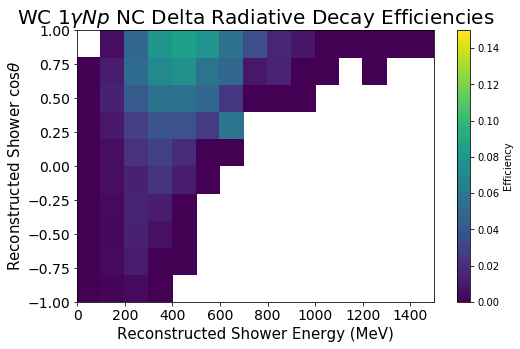

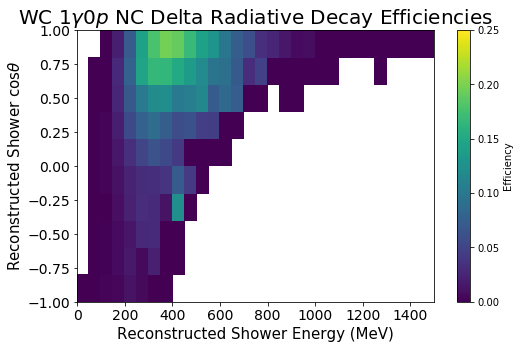

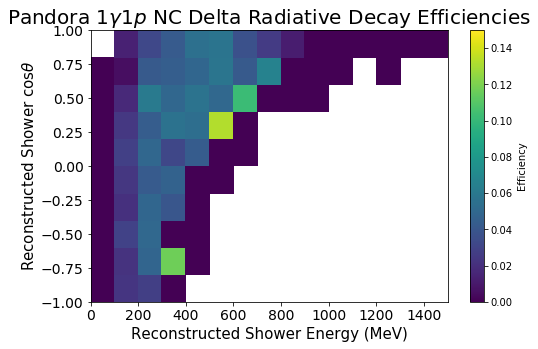

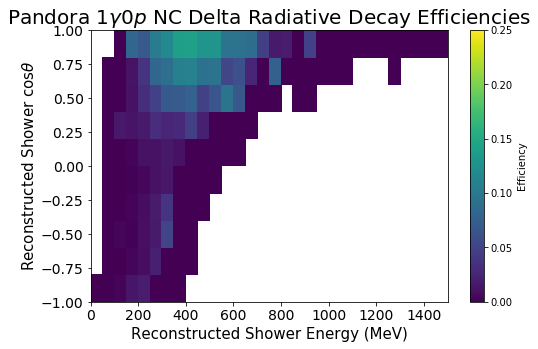

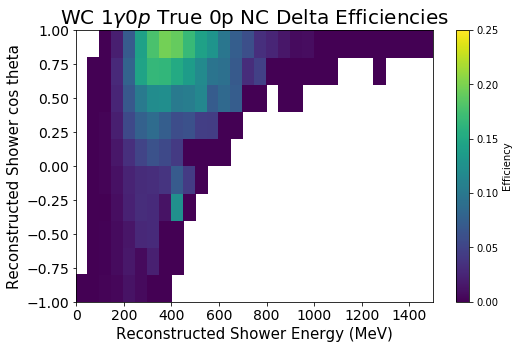

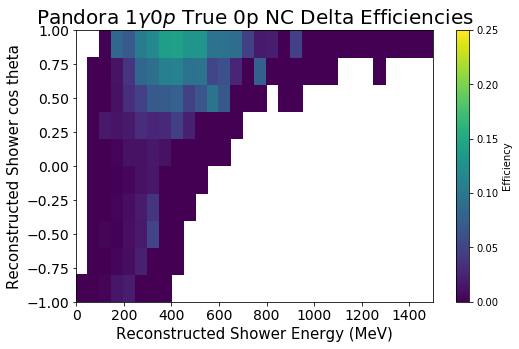

In [17]:
for i in range(len(yaml_names)):
    
    #### PULL 2D DATASET X-AXIS #######
    
    #Check for 2D, 2 and only 2 indepedent variables
    assert len(yaml_dict[yaml_names[i]]["independent_variables"]) == 2, "Plotting 2D only"
    indep_var1 = yaml_dict[yaml_names[i]]["independent_variables"][0]
    indep_var2 = yaml_dict[yaml_names[i]]["independent_variables"][1]
    var1_header = yaml_dict[yaml_names[i]]["independent_variables"][0]["header"]
    var2_header = yaml_dict[yaml_names[i]]["independent_variables"][1]["header"]

    assert len(indep_var1["values"]) == len(indep_var2["values"])
    
    #### PULL DATASET COLUMNS, if more than 1, make more than 1 plot ###############
    data_list = yaml_dict[yaml_names[i]]["dependent_variables"]

    # Extract y-values per column
    data_series = {}
    for entry in data_list:
        name = entry['header']['name']
        zvar_name = name.replace(" ","")
        assert len(indep_var1["values"]) == len(entry["values"])

        z_values = []
        x_values = []
        y_values = []
        for index in range(len(entry['values'])):
            x_values.append(indep_var1["values"][index]["value"])
            y_values.append(indep_var2["values"][index]["value"])
            z_values.append(entry["values"][index]['value'])

        X = np.unique(x_values)
        Y = np.unique(y_values)
        Z = np.zeros((len(X), len(Y)))
        X_bin = (X[1:] - X[:-1]) #bin sizes for plots
        Y_bin = (Y[1:] - Y[:-1])
        X_bin = np.append(X_bin, X_bin[-1]) #Guessing upper bound, since it's not given
        Y_bin = np.append(Y_bin,Y_bin[-1]) #Guessing upper bound, since it's not given

        # Fill Z matrix -- NEED TO CHECK INPUT ORDER OF DATASET (accounted for here)
        for yi in range(len(Y)):
            for xi in range(len(X)):
                index_here = yi * len(X) + xi
                y_index = len(Y)-yi-1 #y start from 1 and go to -1
                Z[xi, y_index] = z_values[index_here] 
        plt.figure(figsize=(8, 5))
        X_plot = np.append(X, X[-1]+X_bin[-1]) #pcolormesh needs len(X) + 1 to plot all of Z
        Y_plot = np.append(Y,Y[-1]+Y_bin[-1]) #pcolormesh needs len(Y) + 1 to plot all of Z
        if "0p" in yaml_name_pretty[i]: #Match vmax range in paper
            plt.pcolormesh(X_plot, Y_plot, Z.T, shading='auto', cmap='viridis',vmax=0.25)  # Transpose Z to match orientation
        else:
            plt.pcolormesh(X_plot, Y_plot, Z.T, shading='auto', cmap='viridis',vmax=0.15)  # Transpose Z to match orientation

        # Format plot
        plt.title(yaml_name_pretty[i],fontsize=20)
        plt.colorbar(label=name)
        plt.xlabel(var1_header["name"],fontsize=15)
        plt.ylabel(var2_header["name"],fontsize=15)
        plt.xticks(fontsize=14)  # Bigger x-axis ticks
        plt.yticks(fontsize=14) 
        plt.savefig(yamlDir + "/plot_" + yaml_names[i] + "_" + zvar_name + ".png") 
      

## Covariance Matrix

In [18]:
yaml_names = file_list_cov
yaml_name_pretty = file_name_cov
yaml_dict = {}
for yaml_file in yaml_names:
    print(yaml_file)
    with open(yamlDir + "/" + yaml_file + ".yaml", "r") as stream:
        try:
            yaml_dict[yaml_file] = yaml.safe_load(stream)  # Load all YAML documents
        except yaml.YAMLError as exc:
            print(exc)

constr_sig_covariance_matrix
covariance_matrix
constr_energies_covariance_matrix


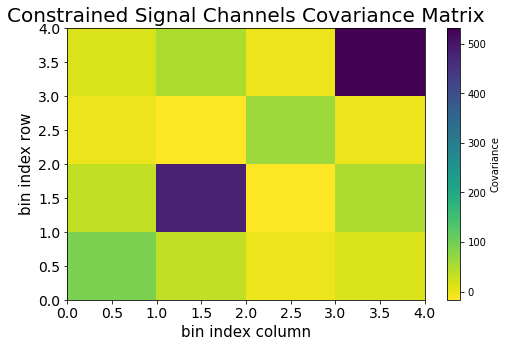

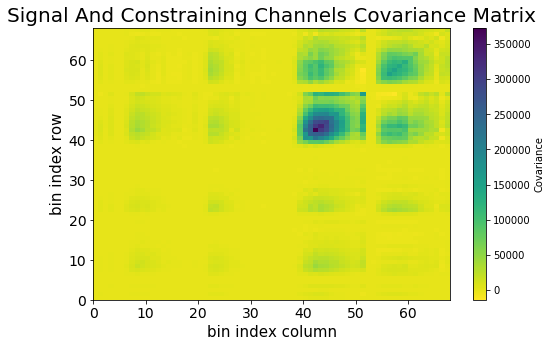

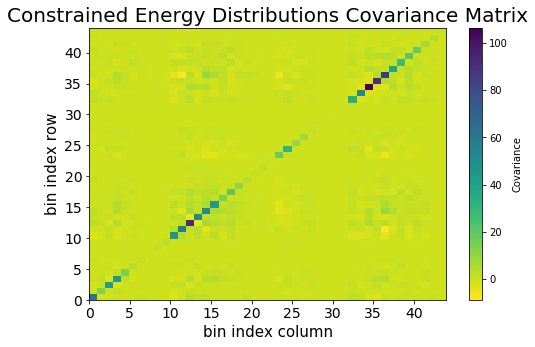

In [33]:
for i in range(len(yaml_names)):
    
    #### PULL 2D DATASET X-AXIS #######
    
    #Check for 2D, 2 and only 2 indepedent variables
    assert len(yaml_dict[yaml_names[i]]["independent_variables"]) == 2, "Plotting 2D only"
    indep_var1 = yaml_dict[yaml_names[i]]["independent_variables"][0]
    indep_var2 = yaml_dict[yaml_names[i]]["independent_variables"][1]
    var1_header = yaml_dict[yaml_names[i]]["independent_variables"][0]["header"]
    var2_header = yaml_dict[yaml_names[i]]["independent_variables"][1]["header"]

    assert len(indep_var1["values"]) == len(indep_var2["values"])
    
    #### PULL DATASET COLUMNS, if more than 1, make more than 1 plot ###############
    data_list = yaml_dict[yaml_names[i]]["dependent_variables"]

    # Extract y-values per column
    for entry in data_list:
        name = entry['header']['name']
        zvar_name = name.replace(" ","")
        assert len(indep_var1["values"]) == len(entry["values"])

        z_values = []
        x_values = []
        y_values = []
        for index in range(len(entry['values'])):
            x_values.append(indep_var1["values"][index]["value"])
            y_values.append(indep_var2["values"][index]["value"])
            z_values.append(entry["values"][index]['value'])

        X = np.unique(x_values)
        Y = np.unique(y_values)
        Z = np.zeros((len(X), len(Y)))
        X_bin = (X[1:] - X[:-1]) #bin sizes for plots
        Y_bin = (Y[1:] - Y[:-1])
        X_bin = np.append(X_bin, X_bin[-1]) #Guessing upper bound, since it's not given
        Y_bin = np.append(Y_bin,Y_bin[-1]) #Guessing upper bound, since it's not given

        # Fill Z matrix
        for xi in range(len(X)):
            for yi in range(len(Y)):
                Z[xi, yi] = z_values[xi*len(Y)+yi]
        X_plot = np.append(X, X[-1]+X_bin[-1]) #pcolormesh needs len(X) + 1 to plot all of Z
        Y_plot = np.append(Y,Y[-1]+Y_bin[-1]) #pcolormesh needs len(Y) + 1 to plot all of Z
        plt.figure(figsize=(8, 5))
        plt.pcolormesh(X_plot, Y_plot, Z.T, shading='auto', cmap='viridis_r')  # Transpose Z to match orientation

        # Format plot
        plt.title(yaml_name_pretty[i],fontsize=20)
        plt.colorbar(label=name)
        plt.xlabel(var1_header["name"],fontsize=15)
        plt.ylabel(var2_header["name"],fontsize=15)
        plt.xticks(fontsize=14)  # Bigger x-axis ticks
        plt.yticks(fontsize=14) 
        #plt.legend()
        plt.savefig(yamlDir + "/plot_" + yaml_names[i] + "_" + zvar_name + ".png")

## Calculate Chi^2 while Matching Covariance to 1D plots

In [34]:
yaml_1D_files = file_list_1D
yaml_1D_names = file_name_1D
yaml_dict_1D = {}
for yaml_file in yaml_1D_files:
    print(yaml_file)
    with open(yamlDir + "/" + yaml_file + ".yaml", "r") as stream:
        try:
            yaml_dict_1D[yaml_file] = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)

signals
constraining_channels
wc_1gNp_energy
wc_1g0p_energy
pandora_1g1p_energy
pandora_1g0p_energy


In [35]:
## Signal Channels Covariance Matrix


#Pull 1D singal  data and prediction values and concatenate
data_list_1D = yaml_dict_1D["signals"]["dependent_variables"] #signal
data_series_signal = pull_dependent_vars(data_list_1D)
full_data = np.array(data_series_signal["Data"]["values"])
full_pred = np.array(data_series_signal["Constrained Prediction"]["values"])

# Pull convariance Matrix
covariance_name = "constr_sig_covariance_matrix"
data_list = yaml_dict[covariance_name]["dependent_variables"]

assert len(yaml_dict[covariance_name]["independent_variables"]) == 2, "Plotting 2D only"
indep_var1 = yaml_dict[covariance_name]["independent_variables"][0]
indep_var2 = yaml_dict[covariance_name]["independent_variables"][1]
var1_header = yaml_dict[covariance_name]["independent_variables"][0]["header"]
var2_header = yaml_dict[covariance_name]["independent_variables"][1]["header"]


for entry in data_list:    
    name = entry['header']['name']
    zvar_name = name.replace(" ","")
    assert len(indep_var1["values"]) == len(entry["values"])

    z_values = []
    x_values = []
    y_values = []
    for index in range(len(entry['values'])):
        x_values.append(indep_var1["values"][index]["value"])
        y_values.append(indep_var2["values"][index]["value"])
        z_values.append(entry["values"][index]['value'])

    X = np.unique(x_values)
    Y = np.unique(y_values)
    Z = np.zeros((len(X), len(Y)))

    # Fill Z matrix
    for xi in range(len(X)):
        for yi in range(len(Y)):
            Z[xi, yi] = z_values[xi*len(Y)+yi]
    cov_matrix = np.array(Z)
    #stat_cov accounted for already in given covariance
    total_cov = cov_matrix
    
    chi2 = np.linalg.multi_dot(
            [np.transpose(full_pred - full_data),
             np.linalg.inv(total_cov), 
             full_pred - full_data])
    print(covariance_name, chi2)

constr_sig_covariance_matrix 2.6565169608225694


In [36]:
## Signal And Constraining Channels Covariance Matrix


#Pull 1D data and prediction values and concatenate
data_list_1D = yaml_dict_1D["signals"]["dependent_variables"] #signal
data_series_signal = pull_dependent_vars(data_list_1D)
data_list_1D = yaml_dict_1D["constraining_channels"]["dependent_variables"] #constrain
data_series_constrain = pull_dependent_vars(data_list_1D)
#Constrain Only
#full_data = np.array(data_series_constrain["Data"]["values"])
#full_pred = np.array(data_series_constrain["Prediction"]["values"])
#Signal + Constrain
full_data = np.concatenate((np.array(data_series_signal["Data"]["values"]),
                            np.array(data_series_constrain["Data"]["values"])))
full_pred = np.concatenate((np.array(data_series_signal["Constrained Prediction"]["values"]), 
                            np.array(data_series_constrain["Prediction"]["values"])))

# Pull covariance Matrix
covariance_name = "covariance_matrix"
data_list = yaml_dict[covariance_name]["dependent_variables"]

assert len(yaml_dict[covariance_name]["independent_variables"]) == 2, "Plotting 2D only"
indep_var1 = yaml_dict[covariance_name]["independent_variables"][0]
indep_var2 = yaml_dict[covariance_name]["independent_variables"][1]
var1_header = yaml_dict[covariance_name]["independent_variables"][0]["header"]
var2_header = yaml_dict[covariance_name]["independent_variables"][1]["header"]


for entry in data_list:    
    name = entry['header']['name']
    zvar_name = name.replace(" ","")
    assert len(indep_var1["values"]) == len(entry["values"])

    z_values = []
    x_values = []
    y_values = []
    for index in range(len(entry['values'])):
        x_values.append(indep_var1["values"][index]["value"])
        y_values.append(indep_var2["values"][index]["value"])
        z_values.append(entry["values"][index]['value'])

    X = np.unique(x_values)
    Y = np.unique(y_values)
    Z = np.zeros((len(X), len(Y)))
    
    # Fill Z matrix
    for xi in range(len(X)):
        for yi in range(len(Y)):
            Z[xi, yi] = z_values[xi*len(Y)+yi]
    cov_matrix = np.array(Z)
    dof = len(full_pred)

    total_cov = cov_matrix 
    chi2 = np.linalg.multi_dot(
            [np.transpose(full_pred - full_data),
             np.linalg.inv(total_cov), 
             full_pred - full_data])
    print(covariance_name, chi2, dof)

covariance_matrix 50.53288195364718 68


In [38]:
## Constrained Energy Covariance Matrix

#Get the covariance matrix
# Pull convariance Matrix
covariance_name = "constr_energies_covariance_matrix"
data_list = yaml_dict[covariance_name]["dependent_variables"]

assert len(yaml_dict[covariance_name]["independent_variables"]) == 2, "Plotting 2D only"
indep_var1 = yaml_dict[covariance_name]["independent_variables"][0]
indep_var2 = yaml_dict[covariance_name]["independent_variables"][1]
var1_header = yaml_dict[covariance_name]["independent_variables"][0]["header"]
var2_header = yaml_dict[covariance_name]["independent_variables"][1]["header"]
for entry in data_list:    
    name = entry['header']['name']
    zvar_name = name.replace(" ","")
    assert len(indep_var1["values"]) == len(entry["values"])

    z_values = []
    x_values = []
    y_values = []
    for index in range(len(entry['values'])):
        x_values.append(indep_var1["values"][index]["value"])
        y_values.append(indep_var2["values"][index]["value"])
        z_values.append(entry["values"][index]['value'])

    X = np.unique(x_values)
    Y = np.unique(y_values)
    Z = np.zeros((len(X), len(Y)))

    # Fill Z matrix
    for xi in range(len(X)):
        for yi in range(len(Y)):
            Z[xi, yi] = z_values[xi*len(Y)+yi]


#Pull 1D data and prediction values and concatenate
energy_list = ["wc_1gNp_energy", "wc_1g0p_energy", "pandora_1g1p_energy", "pandora_1g0p_energy"]
index_start = [0, 7, 22, 29,44]
counter = 0
for file_1D in energy_list:
    data_list_1D = yaml_dict_1D[file_1D]["dependent_variables"] #signal
    data_series_values = pull_dependent_vars(data_list_1D)
    full_data = np.array(data_series_values["Data"]["values"])
    full_pred = np.array(data_series_values["Constrained Prediction"]["values"])
    start_id = index_start[counter]
    end_id = index_start[counter+1]
    print(file_1D,len(full_data))
         
    #Adjust size of cov matrix to only the 1D energy range    
    cov_matrix = np.array(Z[start_id:end_id,start_id:end_id])
    
    total_cov = cov_matrix #+ stat_cov
    chi2 = np.linalg.multi_dot(
            [np.transpose(full_pred - full_data),
             np.linalg.inv(total_cov), 
             full_pred - full_data])
    counter+= 1
    print(covariance_name, chi2)

wc_1gNp_energy 7
constr_energies_covariance_matrix 3.215109828232207
wc_1g0p_energy 15
constr_energies_covariance_matrix 14.431873071168738
pandora_1g1p_energy 7
constr_energies_covariance_matrix 2.1613152181958606
pandora_1g0p_energy 15
constr_energies_covariance_matrix 10.102704697691468


In [40]:
## Constrained Energy Covariance Matrix

#Get the covariance matrix
# Pull convariance Matrix
covariance_name = "constr_energies_covariance_matrix"
data_list = yaml_dict[covariance_name]["dependent_variables"]

assert len(yaml_dict[covariance_name]["independent_variables"]) == 2, "Plotting 2D only"
indep_var1 = yaml_dict[covariance_name]["independent_variables"][0]
indep_var2 = yaml_dict[covariance_name]["independent_variables"][1]
var1_header = yaml_dict[covariance_name]["independent_variables"][0]["header"]
var2_header = yaml_dict[covariance_name]["independent_variables"][1]["header"]
for entry in data_list:    
    name = entry['header']['name']
    zvar_name = name.replace(" ","")
    assert len(indep_var1["values"]) == len(entry["values"])

    z_values = []
    x_values = []
    y_values = []
    for index in range(len(entry['values'])):
        x_values.append(indep_var1["values"][index]["value"])
        y_values.append(indep_var2["values"][index]["value"])
        z_values.append(entry["values"][index]['value'])

    X = np.unique(x_values)
    Y = np.unique(y_values)
    Z = np.zeros((len(X), len(Y)))

    # Fill Z matrix
    for xi in range(len(X)):
        for yi in range(len(Y)):
            Z[xi, yi] = z_values[xi*len(Y)+yi]


#Pull 1D data and prediction values and concatenate
combined_list = ["wc_1gNp_energy", "wc_1g0p_energy", "pandora_1g1p_energy", "pandora_1g0p_energy"]
counter = 0
for file_1D in energy_list:
    data_list_1D = yaml_dict_1D[file_1D]["dependent_variables"] #signal
    data_series_values = pull_dependent_vars(data_list_1D)
    if counter == 0:
        full_data = np.array(data_series_values["Data"]["values"])
        full_pred = np.array(data_series_values["Constrained Prediction"]["values"])
        counter+=1
    else:
        full_data = np.concatenate((full_data,
                            np.array(data_series_values["Data"]["values"])))
        full_pred = np.concatenate((full_pred, 
                            np.array(data_series_values["Constrained Prediction"]["values"])))
    print(file_1D,len(full_data))
         
#Adjust size of cov matrix to only the 1D energy range    
cov_matrix = np.array(Z)


total_cov = cov_matrix 
chi2 = np.linalg.multi_dot(
        [np.transpose(full_pred - full_data),
         np.linalg.inv(total_cov), 
         full_pred - full_data])
counter+= 1
print(covariance_name, chi2)

wc_1gNp_energy 7
wc_1g0p_energy 22
pandora_1g1p_energy 29
pandora_1g0p_energy 44
constr_energies_covariance_matrix 31.49630763217012
